# Max-Cut QAOA on QCS with Qiskit

> ℹ️ Originally written to demonstrate pyQuil, this notebook demonstrates how to take existing pyQuil work and run it on a Rigetti backend using Qiskit.

In this notebook, we will walk through how to run the **Max-Cut QAOA** algorithm using the Qiskit Rigetti Provider.

In [1]:
from typing import List, Tuple

import networkx as nx
import numpy as np

## Generate Random Weighted Graph

Given a list of edges, we generate a graph with random edge weights in the range \[-1,1).

In [2]:
def generate_ising_graph(edges: List[Tuple[int, int]], seed: int) -> nx.Graph:
    np.random.seed(seed)
    graph = nx.from_edgelist(edges)
    weights:  np.ndarray = 2.0 * np.random.rand(graph.number_of_edges()) - 1.0
    weights /= np.linalg.norm(weights)
    nx.set_edge_attributes(graph, {e: {'w': w} for e, w in zip(graph.edges, weights)})
    return graph

## Compute Bitstring Cut Weight

Given a graph and a bitstring, compute the [cut weight](https://en.wikipedia.org/wiki/Maximum_cut), which determines the cost of the particular bitstring.

In [3]:
def bitstring_cut_weight(b: List[List[int]], graph: nx.Graph) -> dict:
    cost = 0
    inverse_map = {qubit: idx for idx, qubit in enumerate(list(graph.nodes))}
    for q0, q1 in graph.edges():
        cost += graph.get_edge_data(q0, q1)['w'] * (-1) ** int(b[inverse_map[q0]] != b[inverse_map[q1]])
    return cost

## Create QAOA Max-Cut Program

For our problem graph, we generate the [QAOA](https://arxiv.org/abs/1411.4028) cost and driver unitaries:

$$H_c = \sum_{i,j} w_{i,j} \sigma_i^z \sigma_j^z \qquad H_d = \sum_i \sigma_i^x$$

From these, we create our parameterized circuit.

In [4]:
from qiskit.circuit import QuantumCircuit, Parameter

def maxcut_qaoa_circuit(graph: nx.Graph, beta: Parameter, gamma: Parameter) -> QuantumCircuit:
    circuit = QuantumCircuit(max(graph.nodes)+1, len(graph.nodes))
    
    circuit.h(graph.nodes)
    
    # cost
    for i, j in graph.edges:
        w = graph.get_edge_data(i, j)['w']
        circuit.cx(i, j)
        circuit.rz(2.0*w*gamma, j)
        circuit.cx(i, j)
    
    # driver
    for i in graph.nodes:
        circuit.h(i)
        circuit.rz(2.0*beta, i)
        circuit.h(i)
    
    circuit.measure(graph.nodes, range(len(graph.nodes)))
    
    return circuit

## Run the Landscape

Given a list of edges and a QPU- or QVM-based backend, generate the Max-Cut QAOA circuit, transpile it to a parametric circuit, and rapidly iterate through the landscape of (β, 𝛾). For each job, we compute the average cost, which will become the $z$-axis of the landscape.

In [5]:
import itertools
from tqdm import tqdm
from qiskit import transpile
from qiskit.providers import Backend
from qiskit_rigetti.hooks.pre_execution import enable_active_reset

def run_maxcut_qaoa_landscape(
    backend: Backend,
    edges: List[Tuple[int, int]],
    width: int,
    shots: int,
    seed: int,
) -> np.ndarray:
    graph = generate_ising_graph(edges, seed)
    beta = Parameter("beta")
    gamma = Parameter("gamma")
    circuit = maxcut_qaoa_circuit(graph, beta, gamma)
    transpiled = transpile(circuit, backend=backend)
    
    costs = []
    angle_range = np.linspace(0, np.pi, width)
    landscape = list(itertools.product(angle_range, angle_range))
    
    def to_array(bitstring: str) -> List[str]:
        return [int(bit) for bit in bitstring]

    for b, g in tqdm(landscape):
        results = backend.run(
            transpiled.bind_parameters({beta: b, gamma: g}),
            before_execute=[enable_active_reset],  # enable active reset to speed up iteration on QPUs
            shots=shots,
        ).result()
        bitstrings = np.array([to_array(bitstring) for bitstring in results.get_memory()])
        costs.append(np.mean([bitstring_cut_weight(list(b), graph) for b in bitstrings]))

    return np.array(costs).reshape(width, width)

## Plot the Landscape

Given results from running QAOA, plot the landscape and the max cost value (shown as a red dot).

In [6]:
import matplotlib.pyplot as plt

def plot_landscape(landscape: np.ndarray, *, device: str, edges: List[Tuple[int, int]],
                   width: int, shots: int):
    max_x, max_y = (np.argmax(landscape) % width, np.argmax(landscape) // width)
    plt.imshow(landscape, extent=[0, np.pi, np.pi, 0])
    plt.plot((max_x + 0.5) * np.pi / width, (max_y + 0.5) * np.pi / width, 'ro')
    plt.colorbar()
    plt.xlabel('beta (radians)')
    plt.ylabel('gamma (radians)')
    plt.title(f'Max-Cut QAOA Landscape\n{device}\n{edges}\nwidth = {width} shots = {shots}')
    plt.show()

## Device Information

We can execute our algorithm on either a QPU or a simulator.

In [7]:
from qiskit_rigetti import RigettiQCSProvider

provider = RigettiQCSProvider()
backend = provider.get_backend(name="Aspen-9")
simulator = provider.get_simulator(num_qubits=3, noisy=False)

## Landscape Information

In addition to providing the device that we want to run on, we need to provide some more information to build our QAOA landscape. The `width` parameter sets the resolution of the landscape—the width squared is the number of jobs we will run. The `shots` parameter specifies how many repetitions to perform for each (β, 𝛾) angle pair. The `seed` parameter is used when randomly generating the edge weights of our graph, and we can reproduce the same graph by keeping the seed constant. Finally, the `edges` specify the qubits and the topology of the graph that we will run QAOA on. For this example, we use a line graph, but you can create more interesting topologies by changing the edge list.

In [8]:
width = 25
shots = 1000
seed = 19120623
edges_qpu = [(13, 14), (14, 15)]  # edit as necessary
edges_sim = [(0, 1), (1, 2)]  # edit as necessary

## Run and Plot on QPU and QVM

We run the QAOA algorithm on the QPU and the QVM, comparing the max value of each landscape, which should be nearly the same. Small differences can be attributed to gate infidelity and decoherence, and larger ones can come from the presence of more than one "peak" in the landscape (as seen by the presence of multiple yellow blobs).

100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


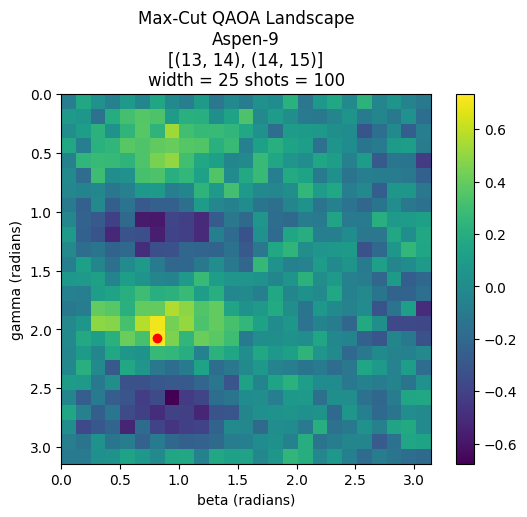

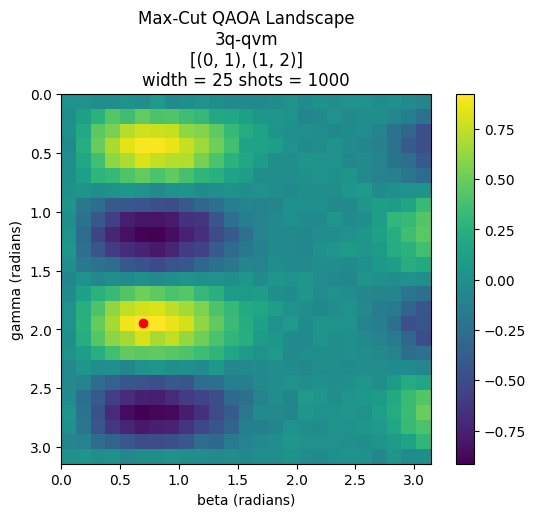

In [9]:
landscape_qpu = run_maxcut_qaoa_landscape(backend, edges_qpu, width, shots, seed)
landscape_sim = run_maxcut_qaoa_landscape(simulator, edges_sim, width, shots, seed)

plot_landscape(landscape_qpu, device=backend.name(), edges=edges_qpu, width=width, shots=shots)
plot_landscape(landscape_sim, device=simulator.name(), edges=edges_sim, width=width, shots=shots)